# Approximating a 1-dimensional function with trained DNN and constructed DNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.11.0


In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Input Variables

In [3]:
# k = dimension
k = 1
# n+1 = count of grid points in each dimension. All grid points = n^k
n = 20
# e = target maximum error
e = 1e-5
# input_dim
input_dim = k
# output_dim
output_dim = 1
# count of hidden_layers
hidden_layers = 3
# count of hidden neurons per layer
hidden_neurons = 1024
# M = [-1,1]
start = -1
stop = 1
# learning rate
lr = 1e-06
# num epochs
epochs = 15000

### Function to Learn

In [4]:
from utils.chebyshev import Chebyshev

As before we use the function $$f(x)=e^{-|x|}(\sin(4\pi x)+\cos(2\pi(x-1/4))).$$

In [5]:
def f(x):
    return np.exp(-1*np.abs(x))*(np.sin(x*np.pi*4)+np.cos(x*np.pi*2-np.pi/2))

In [6]:
cheb = Chebyshev(f,n,k)
degrees, coeffs = cheb.coefficients()

### Building the DNN
We define a class which constructs our model for approximizing our function:

In [7]:
class Regressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, hidden_neurons):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.regressor_stack = torch.nn.Sequential()
        self.regressor_stack.add_module("input_layer", torch.nn.Linear(input_dim, hidden_neurons))
        self.regressor_stack.add_module("relu", torch.nn.ReLU())
        for hidden_layer in range(hidden_layers):
            self.regressor_stack.add_module(f"hidden_layer_{hidden_layer}", torch.nn.Linear(hidden_neurons, hidden_neurons))
            self.regressor_stack.add_module(f"relu_{hidden_layer}",torch.nn.ReLU())
        
        self.regressor_stack.add_module("output_layer", torch.nn.Linear(hidden_neurons, output_dim))
    
    def forward(self, x):
        x = self.flatten(x)
        output = self.regressor_stack(x)
        return output

## Building the Dataset
For testing purposes, we want to build a dataset with n grid values for training and some values for testing.

In [8]:
from utils.helper_functions import generate_grid_points, cos_nd, generate_random_points

def build_dataset(n, k, f_x, start=0, stop=1):
    combinations = generate_grid_points(n=n, k=k)
    cheb = Chebyshev(f,n,k)
    degrees, coeffs = cheb.coefficients()
    
    # Generate the training data
    x = cos_nd(combinations, n)
    y = cheb.interpolate(x, coeffs)
    
    # Convert the training data to PyTorch tensors
    train_x = torch.Tensor(x).unsqueeze(-1).to(device)
    train_y = torch.Tensor(y).unsqueeze(-1).to(device)
    
    # Generate test data
    x_test = generate_random_points(n, k)
    test_x = torch.Tensor(x_test).to(device)
    
    y_test = [f(x) for x[0] in x_test]#cheb.interpolate(np.array(x_test), coeffs)
    test_y = torch.Tensor(y_test).unsqueeze(-1).to(device)
    
    return train_x, train_y, test_x, test_y

## Lets Approximate!

In [9]:
train_x, train_y, test_x, test_y = build_dataset(n=n, k=k, f_x=f, start=start, stop=stop)

/tmp/ipykernel_9222/2159405230.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650977166858/work/torch/csrc/utils/tensor_new.cpp:207.)
  test_y = torch.Tensor(y_test).unsqueeze(-1).to(device)


In [10]:
regression_net = Regressor(input_dim, output_dim, hidden_layers, hidden_neurons)
regression_net.to(device)
print(regression_net)

Regressor(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (regressor_stack): Sequential(
    (input_layer): Linear(in_features=1, out_features=1024, bias=True)
    (relu): ReLU()
    (hidden_layer_0): Linear(in_features=1024, out_features=1024, bias=True)
    (relu_0): ReLU()
    (hidden_layer_1): Linear(in_features=1024, out_features=1024, bias=True)
    (relu_1): ReLU()
    (hidden_layer_2): Linear(in_features=1024, out_features=1024, bias=True)
    (relu_2): ReLU()
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)


### Training the Network

In [11]:
def train(network, train_x, train_y, epochs, optimizer, criterion):
    network.train()
    losses = []
    epochs_trained = 0
    # Create a data loader    
    test_data = torch.utils.data.TensorDataset(test_x, test_y)
    test_loader = torch.utils.data.DataLoader(test_data)
    for epoch in range(1, epochs):  
        # Forward pass
        outputs = network(train_x)
        loss = criterion(outputs, train_y)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        epochs_trained += 1
        # validate the model and early stop if validation loss < e
        val_losses = []
        with torch.no_grad():
            outputs = network(test_x)
            val_loss = criterion(outputs, test_y)
            val_losses.append(val_loss.item())
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
        
        if val_loss < e:
            print(f"Validation Loss of {val_loss} < {e} = e. Stopping after {epochs_trained} epochs.")
            break
    return losses, epochs_trained

## Training Parameters

In [12]:
optimizer = torch.optim.Adam(regression_net.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction="mean")

## Let's Go!

Training...


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([20, 21, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1000/15000], Loss: 0.2463091015815735, Validation Loss: 0.3790279030799866
Epoch [2000/15000], Loss: 0.15012453496456146, Validation Loss: 0.41547590494155884
Epoch [3000/15000], Loss: 0.08788751065731049, Validation Loss: 0.4953061640262604
Epoch [4000/15000], Loss: 0.05993489548563957, Validation Loss: 0.5700283050537109
Epoch [5000/15000], Loss: 0.04133128374814987, Validation Loss: 0.6240020990371704
Epoch [6000/15000], Loss: 0.025180881842970848, Validation Loss: 0.6599531173706055
Epoch [7000/15000], Loss: 0.010065668262541294, Validation Loss: 0.7123823165893555
Epoch [8000/15000], Loss: 0.002226304030045867, Validation Loss: 0.7675617337226868
Epoch [9000/15000], Loss: 0.00031294376822188497, Validation Loss: 0.8004480600357056
Epoch [10000/15000], Loss: 3.68163782695774e-05, Validation Loss: 0.8150736689567566
Epoch [11000/15000], Loss: 1.6138153569045244e-06, Validation Loss: 0.8202533721923828
Epoch [12000/15000], Loss: 2.942250532100843e-08, Validation Loss: 0.821240

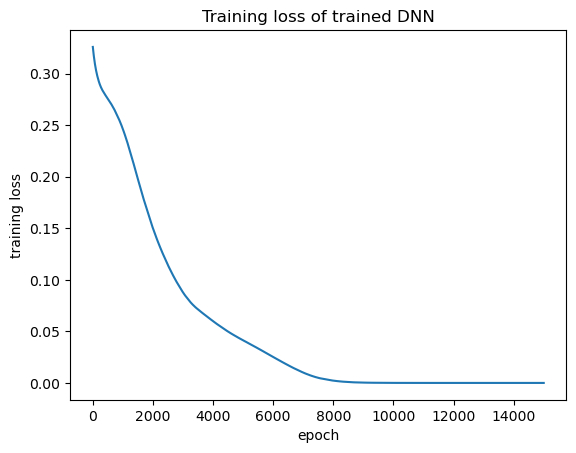

In [13]:
print ("Training...")
losses, epochs_trained = train(network=regression_net, train_x=train_x, train_y=train_y, epochs=epochs, optimizer=optimizer, criterion=criterion)

plt.plot(range(0, epochs_trained), losses)
plt.title("Training loss of trained DNN")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

## Testing the trained model

In [14]:
# Test the network
predictions = regression_net(test_x)
loss = criterion(predictions, test_y)

print(f"Validation Loss: {loss.item()}")

Validation Loss: 0.8212614059448242


## Visualizing

torch.Size([20, 1])


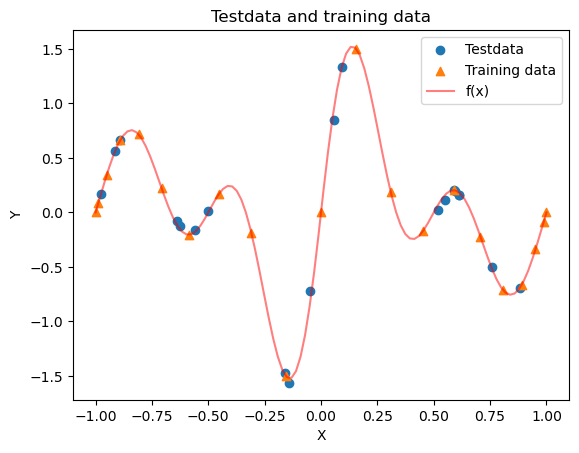

In [15]:
y_test = predictions.cpu().detach().numpy()
print(test_x.shape)

fig, ax = plt.subplots()
X = test_x.cpu().detach().numpy()
Z = y_test

x, z = zip(*sorted(zip(X, Z)))

ax.set_title('Testdata and training data')
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.scatter(x, z,label="Testdata")


X = train_x.cpu().detach().numpy()
Z = train_y.cpu().detach().numpy()

x, z = zip(*sorted(zip(X, Z)))

ax.scatter(x, z,label="Training data",marker='^')
x = np.linspace(-1,1,100)
ax.plot(x,f(x),'r',label="f(x)",alpha=0.5)
plt.legend()
plt.show()

Iteration: 1 Error: 2.4338271331636463e-07, n: 21, delta: 0.5
Iteration: 2 Error: 4.802612457721622e-08, n: 22, delta: 0.5
Iteration: 3 Error: 2.9165257681151857e-08, n: 22, delta: 0.25
Iteration: 4 Error: 2.9165257681151857e-08, n: 23, delta: 0.25
Iteration: 5 Error: 2.3606715582324966e-08, n: 23, delta: 0.125
Iteration: 6 Error: 1.0480488067676763e-08, n: 23, delta: 0.0625
Iteration: 7 Error: 2.6033327160668307e-09, n: 23, delta: 0.03125
Iteration: 8 Error: 5.44085443365816e-10, n: 23, delta: 0.015625
Total depth: 212, Total size: 76746, n: 23, delta: 0.03125, error: 5.44085443365816e-10. Reached after 9 iterations.
Error: L_infty error: 0.02179223862290014, MSE: 7.729669209897859e-05


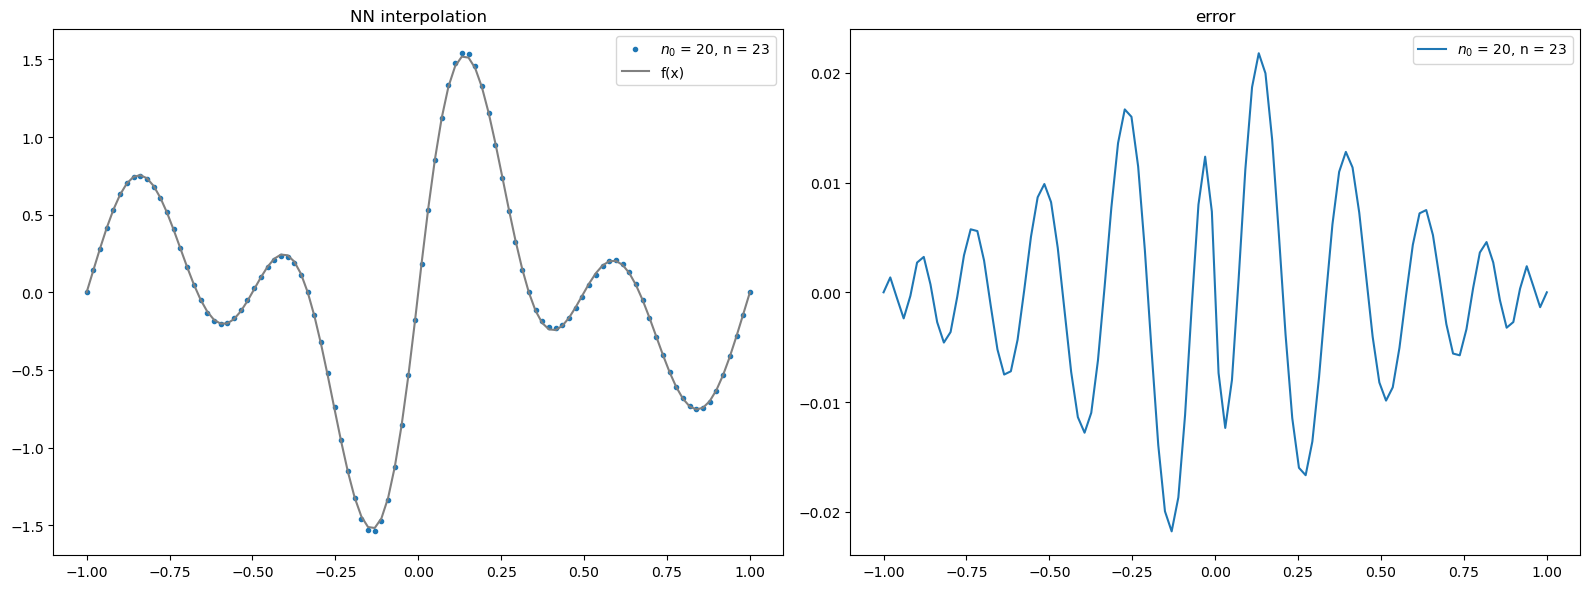

In [16]:
from dnn_construction import compute_dnn

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax = ax.ravel()

net = compute_dnn(1,f,1e-09,0.5,0.5,n)
#n=5
#net = compute_dnn(1,f,1e-1,0.5,0.9,n)
y_net = np.array([net[0].realize(xi) for xi in x])
ax[0].plot(x,y_net,'.',label=f"$n_0$ = 20, n = {net[3]}")
ax[1].plot(x,y_net-f(x),label=f"$n_0$ = 20, n = {net[3]}")
print(f"Error: L_infty error: {np.max(np.abs(y_net-f(x)))}, MSE: {np.mean((y_net-f(x))**2)}")

ax[0].plot(x,f(x),'grey',label='f(x)')
ax[0].set_title('NN interpolation')
ax[0].legend()
ax[1].set_title('error')
ax[1].legend()
plt.tight_layout()
plt.show()

## Construct a DNN of same size as constructed DNN

In [17]:
weights = net[0].weights
biases = net[0].biases
dims = net[0].hidden_dims

In [18]:
class NNRegressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.regressor_stack = torch.nn.Sequential()
        self.regressor_stack.add_module("input_layer", torch.nn.Linear(input_dim, hidden_dims[0]))
        self.regressor_stack.add_module("relu", torch.nn.ReLU())
        for i in range(1,len(hidden_dims)):
            self.regressor_stack.add_module(f"hidden_layer_{i}", torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.regressor_stack.add_module(f"relu_{i}",torch.nn.ReLU())
        
        self.regressor_stack.add_module("output_layer", torch.nn.Linear(hidden_dims[-1], output_dim))
    
    def forward(self, x):
        x = self.flatten(x)
        output = self.regressor_stack(x)
        return output
        

In [19]:
nn = NNRegressor(input_dim,output_dim,dims)
nn.to(device)
print("")

And fill it with the constructed weights and biases

In [20]:
i = 0
#with torch.no_grad():
for name, layer in nn.named_modules():
    if isinstance(layer, torch.nn.Linear):
        layer.weight = torch.nn.Parameter(torch.from_numpy(weights[i].astype(np.float32)).to(device))
        layer.bias = torch.nn.Parameter(torch.from_numpy(biases[i].astype(np.float32)).to(device))
        i+=1

Training...
Epoch [1000/1000], Loss: 5.673582109011477e-06, Validation Loss: 0.8681747317314148


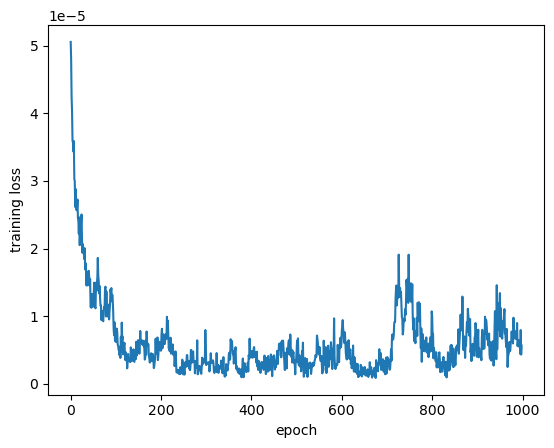

In [21]:
print ("Training...")
lr = 1e-09
train_x, train_y, test_x, test_y = build_dataset(n=20, k=k, f_x=f, start=start, stop=stop)
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction="mean")
losses, epochs_trained = train(network=nn, train_x=train_x, train_y=train_y, epochs=1000 ,optimizer=optimizer,criterion=criterion)

plt.plot(range(0, epochs_trained), losses)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

Lets see, if our net does the correct thing?

In [22]:
# Test the network
predictions = nn(test_x)
loss = criterion(predictions, test_y)

print(f"Validation Loss: {loss.item()}")

Validation Loss: 0.8681747317314148


torch.Size([20, 1])


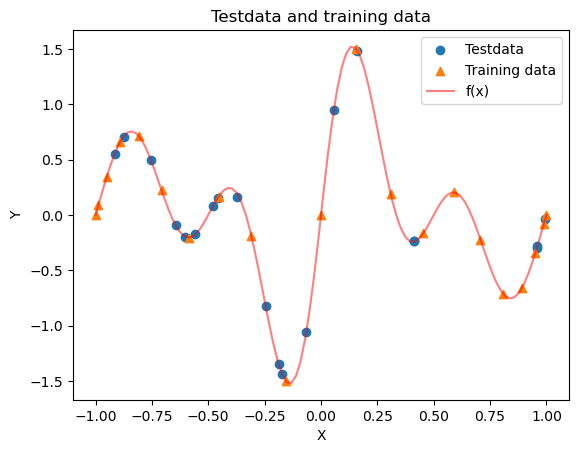

In [23]:
y_test = predictions.cpu().detach().numpy()
print(test_x.shape)

fig, ax = plt.subplots()
#ax = fig.add_subplot()
X = test_x.cpu().detach().numpy()
Z = y_test

x, z = zip(*sorted(zip(X, Z)))

ax.set_title('Testdata and training data')
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.scatter(x, z,label="Testdata")


X = train_x.cpu().detach().numpy()
Z = train_y.cpu().detach().numpy()

x, z = zip(*sorted(zip(X, Z)))

ax.scatter(x, z,label="Training data",marker='^')
x = np.linspace(-1,1,100)
ax.plot(x,f(x),'r',label="f(x)",alpha=0.5)
plt.legend()
plt.show()

Looking good! Now for the training with a worse constructed DNN.

Iteration: 1 Error: 9.103828801926284e-14, n: 6, delta: 0.9
Total depth: 66, Total size: 9382, n: 5, delta: 0.9, error: 9.103828801926284e-14. Reached after 2 iterations.
Error: L_infty error: 1.372989367711862, MSE: 0.3314147786065149


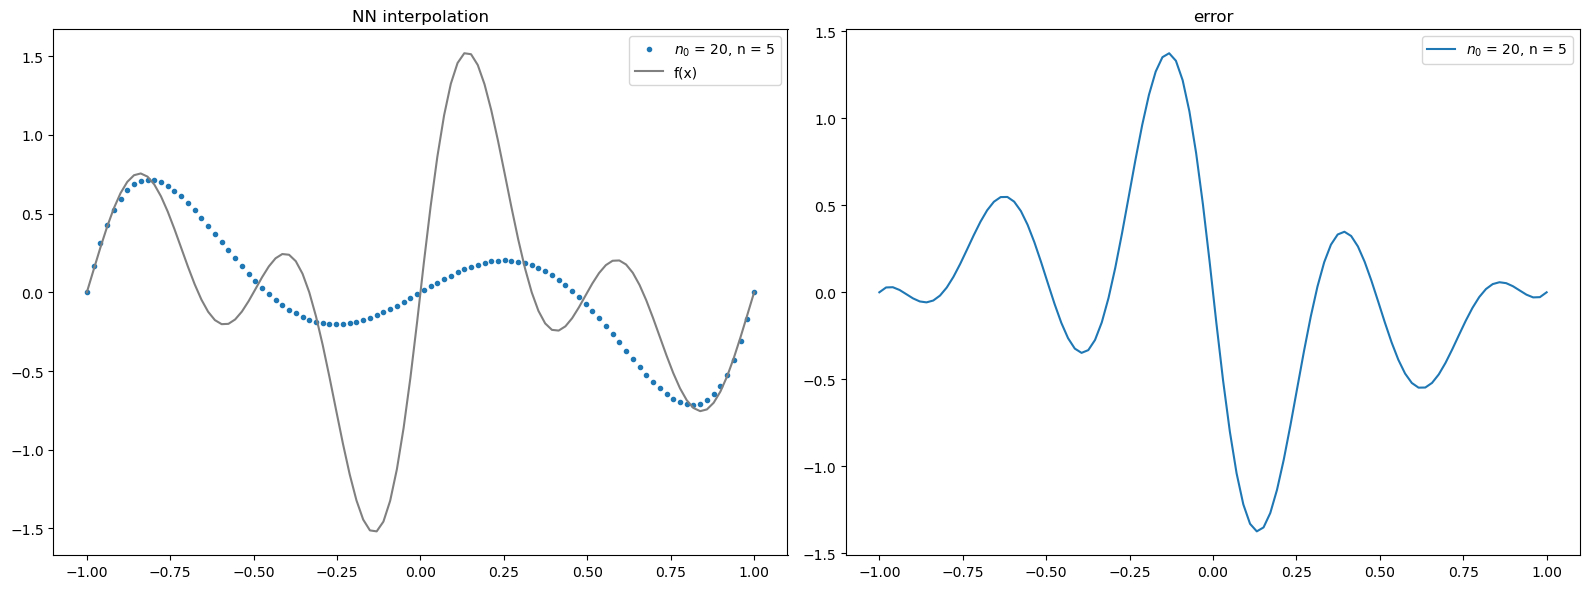

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax = ax.ravel()

#net = compute_dnn(1,f,1e-09,0.5,0.5,n)
n=5
net = compute_dnn(1,f,1e-1,0.5,0.9,n)
y_net = np.array([net[0].realize(xi) for xi in x])
ax[0].plot(x,y_net,'.',label=f"$n_0$ = 20, n = {net[3]}")
ax[1].plot(x,y_net-f(x),label=f"$n_0$ = 20, n = {net[3]}")
print(f"Error: L_infty error: {np.max(np.abs(y_net-f(x)))}, MSE: {np.mean((y_net-f(x))**2)}")

ax[0].plot(x,f(x),'grey',label='f(x)')
ax[0].set_title('NN interpolation')
ax[0].legend()
ax[1].set_title('error')
ax[1].legend()
plt.tight_layout()
plt.show()

In [25]:
weights = net[0].weights
biases = net[0].biases
dims = net[0].hidden_dims

In [26]:
nn = NNRegressor(input_dim,output_dim,dims)
nn.to(device)
print("")

In [27]:
i = 0
with torch.no_grad():
    for name, layer in nn.named_modules():
        if isinstance(layer, torch.nn.Linear):
            layer.weight = torch.nn.Parameter(torch.from_numpy(weights[i].astype(np.float32)).to(device))
            layer.bias = torch.nn.Parameter(torch.from_numpy(biases[i].astype(np.float32)).to(device))
            i+=1

Training...
Epoch [1000/10000], Loss: 0.019054735079407692, Validation Loss: 0.7529947757720947
Epoch [2000/10000], Loss: 0.004383072257041931, Validation Loss: 0.8881837129592896
Epoch [3000/10000], Loss: 0.0033013634383678436, Validation Loss: 0.8518712520599365
Epoch [4000/10000], Loss: 0.002058095298707485, Validation Loss: 0.9444760084152222
Epoch [5000/10000], Loss: 0.0016482662176713347, Validation Loss: 0.9906800985336304
Epoch [6000/10000], Loss: 0.006596269551664591, Validation Loss: 0.9031195044517517
Epoch [7000/10000], Loss: 0.007333341985940933, Validation Loss: 1.0353766679763794
Epoch [8000/10000], Loss: 0.0012583150528371334, Validation Loss: 1.042553424835205
Epoch [9000/10000], Loss: 0.0010577478678897023, Validation Loss: 1.0560177564620972
Epoch [10000/10000], Loss: 0.0006127122323960066, Validation Loss: 1.030746579170227


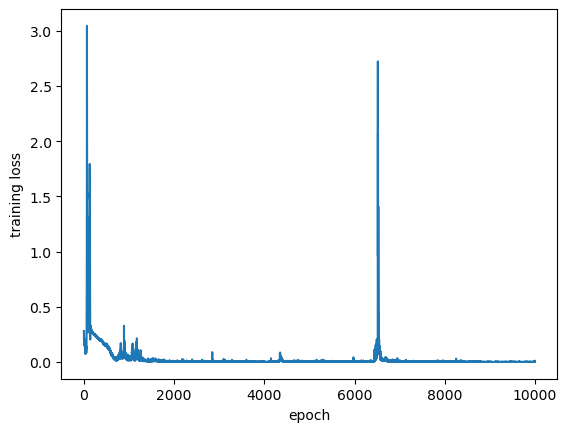

In [28]:
print ("Training...")
lr = 1e-05
train_x, train_y, test_x, test_y = build_dataset(n=20, k=k, f_x=f, start=start, stop=stop)
optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction="mean")
losses, epochs_trained = train(network=nn, train_x=train_x, train_y=train_y, epochs=10000 ,optimizer=optimizer,criterion=criterion)

plt.plot(range(0, epochs_trained), losses)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

Validation Loss: 1.030746579170227
torch.Size([20, 1])


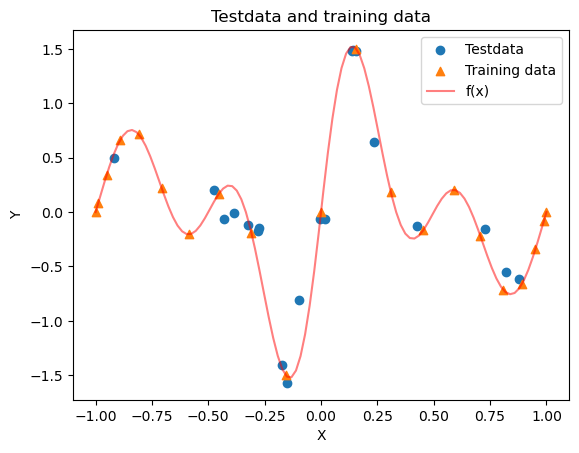

In [29]:
predictions = nn(test_x)
loss = criterion(predictions, test_y)

print(f"Validation Loss: {loss.item()}")

y_test = predictions.cpu().detach().numpy()
print(test_x.shape)

fig, ax = plt.subplots()
#ax = fig.add_subplot()
X = test_x.cpu().detach().numpy()
Z = y_test

x, z = zip(*sorted(zip(X, Z)))

ax.set_title('Testdata and training data')
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.scatter(x, z,label="Testdata")


X = train_x.cpu().detach().numpy()
Z = train_y.cpu().detach().numpy()

x, z = zip(*sorted(zip(X, Z)))

ax.scatter(x, z,label="Training data",marker='^')
x = np.linspace(-1,1,100)
ax.plot(x,f(x),'r',label="f(x)",alpha=0.5)
plt.legend()
plt.show()